In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

# Задача

В данном задании вам предлагается решить задачу извлечения аргументов (объектов, аспектов и предикатов) из предложения. Такая модель должна быть обучена на предложениях, где слова или фразы имеют разметку последовательности – каждому слову соответствует его тег.

> **Пример.** Postgres is easier to install and maintain than Oracle.
>
> [Postgres **OBJECT**] is [easier **PREDICATE**] to [install **ASPECT**] and [maintain **ASPECT**] than [Oracle **OBJECT**].

> Сущности могут состоять из нескольких слов: Advil works better for body aches and pains than Motrin.
>
> [Advil **OBJECT**] works [better **PREDICATE**] for [body aches **ASPECT**] and [pains **ASPECT**] than [Motrin **OBJECT**].

Данные состоят из сравнительных предложений (т.е. предложений, содержащих сравнение двух или более объектов). В предложениях содержится следующая информация:

-	*Объекты* – объекты, которые сравниваются
-	*Аспекты* – характеристики, по которым сравниваются объекты
-	*Сказуемое* – слова или фразы, которые реализуют сравнение (обычно сравнительные прилагательные или наречия)

В наборе данных используется схема BIO:

- Первое слово сущности помечается тегом `B-<entity-type>` (начало сущности).
- Второе и последующие слова сущности помечаются тегом `I-<entity-type>` (внутри сущности).
- Слова, которые не являются частью сущности, помечаются тегом `O` (вне сущности).

Поэтому в нашем наборе данных используются следующие метки:
- O
- B-Object
- I-Object
- B-Aspect
- I-Aspect
- B-Predicate
- I-Predicate

**Ваша задача** – присвоить одну из таких меток каждому токену данных путем обучения модели на основе LSTM.


# Data loading

In [141]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [142]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [143]:
training_data = read_dataset("train.tsv")

In [144]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [145]:
test_data = read_dataset("test_no_answer.tsv", splitter="\n")

In [146]:
test_data[0]

(['meanwhile',
  ',',
  'though',
  'windows',
  '8',
  'is',
  'significantly',
  'at',
  'greater',
  'risk',
  '(',
  '1',
  '.',
  '73',
  'percent',
  ')',
  'compared',
  'to',
  'windows',
  '8',
  '.',
  '1',
  ',',
  'according',
  'to',
  'redmond',
  "'",
  's',
  'report',
  ',',
  'it',
  "'",
  's',
  'still',
  'significantly',
  'safer',
  'than',
  'windows',
  '7',
  ',',
  'windows',
  'xp',
  ',',
  'or',
  'windows',
  'vista',
  '.'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [147]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

EMBEDDING_DIM = 32
HIDDEN_DIM = 64

In [191]:
# Формировываем списки для предложений и меток без padding
training_data_tags = [[torch.Tensor([tag_to_ix[w] for w in x[1]]).long()] for x in training_data]
training_data_sentences = [[torch.Tensor([word_to_ix[w] for w in x[0]]).long()] for x in training_data]

# Tagger

Опишите архитектуру нейросети. Все необходимые слои описаны в комментариях. В качестве выхода из модели используйте логистический softmax:

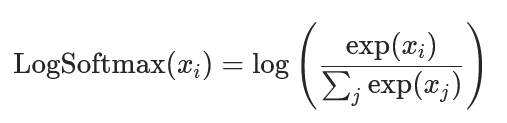

In [239]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        torch.manual_seed(5)
        torch.cuda.manual_seed(5)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.hidden_dim = hidden_dim
        # The Embedding layer with size of the dictionary vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # YOUR CODE HERE
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.rnn = nn.LSTM(embedding_dim, hidden_dim) # YOUR CODE HERE

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_dim, tagset_size) # YOUR CODE HERE

    def forward(self, sentence):
        emb = self.embedding(sentence)
        rnn, _ = self.rnn(emb)  # [L, N, hidden_dim]
        
        # Передаем всю последовательность через сеть
        fc = self.fc(rnn)  # [L, N, tagset_size]
        logsoftmax = nn.LogSoftmax(dim=2)  # Применяем LogSoftmax по ориентации на класс
        tag_scores = logsoftmax(fc)  # [L, N, tagset_size]
        
        return tag_scores


# Training

Обучите модель с представленными ниже параметрами.

In [274]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [275]:
# Цикл обучения
for epoch in tqdm(range(300)):
    model.train()
    optimizer.zero_grad()
    
    losses = []
    
    for sentence, tags in zip(training_data_sentences, training_data_tags):
        # Передаем каждую последовательность по отдельности
        y_predicted = model(sentence[0].reshape(1, -1))  # Переход в размерность [1, L]
        
        # Меняем размерность y_predicted для функции потерь
        y_predicted = y_predicted.permute(1, 0, 2)  # [L, 1, tagset_size]
        loss_input = y_predicted.reshape(-1, len(tag_to_ix))  # [L, tagset_size]
        loss_target = tags[0].reshape(-1)  # [L]
        
        loss = loss_function(loss_input, loss_target)  
        losses.append(loss)
        
        loss.backward()
        
    # Оптимизируем веса
    optimizer.step()
    
    # Среднее значение потерь за epoch
    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}, Average Loss: {sum(losses) / len(losses)}")

  0%|▎                                                                                 | 1/300 [00:02<10:28,  2.10s/it]

Epoch 1, Average Loss: 1.9489020109176636


  1%|▌                                                                                 | 2/300 [00:04<10:28,  2.11s/it]

Epoch 2, Average Loss: 40.4881706237793


  1%|▊                                                                                 | 3/300 [00:06<10:59,  2.22s/it]

Epoch 3, Average Loss: 237.33750915527344


  1%|█                                                                                 | 4/300 [00:08<10:46,  2.18s/it]

Epoch 4, Average Loss: 430.3122253417969


  2%|█▎                                                                                | 5/300 [00:10<10:38,  2.16s/it]

Epoch 5, Average Loss: 155.8293914794922


  2%|█▋                                                                                | 6/300 [00:12<10:30,  2.15s/it]

Epoch 6, Average Loss: 109.67700958251953


  2%|█▉                                                                                | 7/300 [00:15<10:26,  2.14s/it]

Epoch 7, Average Loss: 84.04830932617188


  3%|██▏                                                                               | 8/300 [00:17<10:28,  2.15s/it]

Epoch 8, Average Loss: 69.69403076171875


  3%|██▍                                                                               | 9/300 [00:19<10:21,  2.14s/it]

Epoch 9, Average Loss: 73.76962280273438


  3%|██▋                                                                              | 10/300 [00:21<10:20,  2.14s/it]

Epoch 10, Average Loss: 60.903564453125


  4%|██▉                                                                              | 11/300 [00:23<10:15,  2.13s/it]

Epoch 11, Average Loss: 53.75703048706055


  4%|███▏                                                                             | 12/300 [00:25<10:12,  2.13s/it]

Epoch 12, Average Loss: 43.609771728515625


  4%|███▌                                                                             | 13/300 [00:27<10:09,  2.12s/it]

Epoch 13, Average Loss: 37.710296630859375


  5%|███▊                                                                             | 14/300 [00:29<10:06,  2.12s/it]

Epoch 14, Average Loss: 41.55281448364258


  5%|████                                                                             | 15/300 [00:32<10:05,  2.12s/it]

Epoch 15, Average Loss: 53.52937698364258


  5%|████▎                                                                            | 16/300 [00:34<10:04,  2.13s/it]

Epoch 16, Average Loss: 39.165855407714844


  6%|████▌                                                                            | 17/300 [00:36<10:00,  2.12s/it]

Epoch 17, Average Loss: 36.65617752075195


  6%|████▊                                                                            | 18/300 [00:38<09:58,  2.12s/it]

Epoch 18, Average Loss: 32.87516784667969


  6%|█████▏                                                                           | 19/300 [00:40<09:57,  2.13s/it]

Epoch 19, Average Loss: 35.68231964111328


  7%|█████▍                                                                           | 20/300 [00:42<09:58,  2.14s/it]

Epoch 20, Average Loss: 29.64942169189453


  7%|█████▋                                                                           | 21/300 [00:44<09:55,  2.13s/it]

Epoch 21, Average Loss: 27.607746124267578


  7%|█████▉                                                                           | 22/300 [00:47<09:54,  2.14s/it]

Epoch 22, Average Loss: 29.269588470458984


  8%|██████▏                                                                          | 23/300 [00:49<09:56,  2.15s/it]

Epoch 23, Average Loss: 42.176536560058594


  8%|██████▍                                                                          | 24/300 [00:51<09:51,  2.14s/it]

Epoch 24, Average Loss: 30.728008270263672


  8%|██████▊                                                                          | 25/300 [00:53<09:52,  2.16s/it]

Epoch 25, Average Loss: 35.88923645019531


  9%|███████                                                                          | 26/300 [00:55<09:47,  2.14s/it]

Epoch 26, Average Loss: 28.722238540649414


  9%|███████▎                                                                         | 27/300 [00:57<09:40,  2.13s/it]

Epoch 27, Average Loss: 40.50995635986328


  9%|███████▌                                                                         | 28/300 [00:59<09:39,  2.13s/it]

Epoch 28, Average Loss: 30.678491592407227


 10%|███████▊                                                                         | 29/300 [01:01<09:37,  2.13s/it]

Epoch 29, Average Loss: 29.275672912597656


 10%|████████                                                                         | 30/300 [01:04<09:35,  2.13s/it]

Epoch 30, Average Loss: 25.57602882385254


 10%|████████▎                                                                        | 31/300 [01:06<09:31,  2.13s/it]

Epoch 31, Average Loss: 37.24549102783203


 11%|████████▋                                                                        | 32/300 [01:08<09:30,  2.13s/it]

Epoch 32, Average Loss: 24.369279861450195


 11%|████████▉                                                                        | 33/300 [01:10<09:29,  2.13s/it]

Epoch 33, Average Loss: 27.455299377441406


 11%|█████████▏                                                                       | 34/300 [01:12<09:27,  2.13s/it]

Epoch 34, Average Loss: 27.012304306030273


 12%|█████████▍                                                                       | 35/300 [01:14<09:23,  2.13s/it]

Epoch 35, Average Loss: 30.027671813964844


 12%|█████████▋                                                                       | 36/300 [01:16<09:20,  2.12s/it]

Epoch 36, Average Loss: 32.505184173583984


 12%|█████████▉                                                                       | 37/300 [01:19<09:22,  2.14s/it]

Epoch 37, Average Loss: 25.996292114257812


 13%|██████████▎                                                                      | 38/300 [01:21<09:18,  2.13s/it]

Epoch 38, Average Loss: 26.442562103271484


 13%|██████████▌                                                                      | 39/300 [01:23<09:12,  2.12s/it]

Epoch 39, Average Loss: 40.865169525146484


 13%|██████████▊                                                                      | 40/300 [01:25<09:18,  2.15s/it]

Epoch 40, Average Loss: 31.074857711791992


 14%|███████████                                                                      | 41/300 [01:27<09:11,  2.13s/it]

Epoch 41, Average Loss: 39.02958297729492


 14%|███████████▎                                                                     | 42/300 [01:29<09:11,  2.14s/it]

Epoch 42, Average Loss: 24.368623733520508


 14%|███████████▌                                                                     | 43/300 [01:31<09:07,  2.13s/it]

Epoch 43, Average Loss: 24.033004760742188


 15%|███████████▉                                                                     | 44/300 [01:33<09:02,  2.12s/it]

Epoch 44, Average Loss: 29.42530632019043


 15%|████████████▏                                                                    | 45/300 [01:35<08:58,  2.11s/it]

Epoch 45, Average Loss: 43.8139533996582


 15%|████████████▍                                                                    | 46/300 [01:38<08:55,  2.11s/it]

Epoch 46, Average Loss: 24.03484344482422


 16%|████████████▋                                                                    | 47/300 [01:40<08:55,  2.11s/it]

Epoch 47, Average Loss: 19.90448570251465


 16%|████████████▉                                                                    | 48/300 [01:42<08:54,  2.12s/it]

Epoch 48, Average Loss: 18.768808364868164


 16%|█████████████▏                                                                   | 49/300 [01:44<08:57,  2.14s/it]

Epoch 49, Average Loss: 22.031164169311523


 17%|█████████████▌                                                                   | 50/300 [01:46<09:10,  2.20s/it]

Epoch 50, Average Loss: 25.30636978149414


 17%|█████████████▊                                                                   | 51/300 [01:49<09:11,  2.22s/it]

Epoch 51, Average Loss: 41.34693145751953


 17%|██████████████                                                                   | 52/300 [01:51<09:21,  2.26s/it]

Epoch 52, Average Loss: 22.287221908569336


 18%|██████████████▎                                                                  | 53/300 [01:53<09:22,  2.28s/it]

Epoch 53, Average Loss: 20.2816219329834


 18%|██████████████▌                                                                  | 54/300 [01:56<09:15,  2.26s/it]

Epoch 54, Average Loss: 21.82488250732422


 18%|██████████████▊                                                                  | 55/300 [01:58<09:03,  2.22s/it]

Epoch 55, Average Loss: 23.587255477905273


 19%|███████████████                                                                  | 56/300 [02:00<08:52,  2.18s/it]

Epoch 56, Average Loss: 38.701942443847656


 19%|███████████████▍                                                                 | 57/300 [02:02<08:48,  2.18s/it]

Epoch 57, Average Loss: 23.161462783813477


 19%|███████████████▋                                                                 | 58/300 [02:04<08:43,  2.16s/it]

Epoch 58, Average Loss: 21.84400177001953


 20%|███████████████▉                                                                 | 59/300 [02:06<08:39,  2.16s/it]

Epoch 59, Average Loss: 24.170440673828125


 20%|████████████████▏                                                                | 60/300 [02:08<08:35,  2.15s/it]

Epoch 60, Average Loss: 36.987937927246094


 20%|████████████████▍                                                                | 61/300 [02:10<08:34,  2.15s/it]

Epoch 61, Average Loss: 19.866989135742188


 21%|████████████████▋                                                                | 62/300 [02:13<08:28,  2.14s/it]

Epoch 62, Average Loss: 16.733081817626953


 21%|█████████████████                                                                | 63/300 [02:15<08:26,  2.14s/it]

Epoch 63, Average Loss: 16.273021697998047


 21%|█████████████████▎                                                               | 64/300 [02:17<08:28,  2.15s/it]

Epoch 64, Average Loss: 20.011260986328125


 22%|█████████████████▌                                                               | 65/300 [02:19<08:36,  2.20s/it]

Epoch 65, Average Loss: 39.154598236083984


 22%|█████████████████▊                                                               | 66/300 [02:21<08:31,  2.18s/it]

Epoch 66, Average Loss: 18.16269302368164


 22%|██████████████████                                                               | 67/300 [02:24<08:27,  2.18s/it]

Epoch 67, Average Loss: 15.625256538391113


 23%|██████████████████▎                                                              | 68/300 [02:26<08:22,  2.16s/it]

Epoch 68, Average Loss: 14.425863265991211


 23%|██████████████████▋                                                              | 69/300 [02:28<08:15,  2.14s/it]

Epoch 69, Average Loss: 17.027463912963867


 23%|██████████████████▉                                                              | 70/300 [02:30<08:11,  2.14s/it]

Epoch 70, Average Loss: 33.39667892456055


 24%|███████████████████▏                                                             | 71/300 [02:32<08:09,  2.14s/it]

Epoch 71, Average Loss: 16.874347686767578


 24%|███████████████████▍                                                             | 72/300 [02:34<08:07,  2.14s/it]

Epoch 72, Average Loss: 19.222618103027344


 24%|███████████████████▋                                                             | 73/300 [02:36<08:02,  2.13s/it]

Epoch 73, Average Loss: 23.418842315673828


 25%|███████████████████▉                                                             | 74/300 [02:38<07:58,  2.12s/it]

Epoch 74, Average Loss: 46.065948486328125


 25%|████████████████████▎                                                            | 75/300 [02:41<07:59,  2.13s/it]

Epoch 75, Average Loss: 20.443809509277344


 25%|████████████████████▌                                                            | 76/300 [02:43<07:58,  2.13s/it]

Epoch 76, Average Loss: 18.24799156188965


 26%|████████████████████▊                                                            | 77/300 [02:45<07:56,  2.14s/it]

Epoch 77, Average Loss: 23.99786949157715


 26%|█████████████████████                                                            | 78/300 [02:47<07:52,  2.13s/it]

Epoch 78, Average Loss: 17.903066635131836


 26%|█████████████████████▎                                                           | 79/300 [02:49<07:51,  2.13s/it]

Epoch 79, Average Loss: 34.327266693115234


 27%|█████████████████████▌                                                           | 80/300 [02:51<07:46,  2.12s/it]

Epoch 80, Average Loss: 15.316572189331055


 27%|█████████████████████▊                                                           | 81/300 [02:53<07:45,  2.12s/it]

Epoch 81, Average Loss: 12.490572929382324


 27%|██████████████████████▏                                                          | 82/300 [02:55<07:46,  2.14s/it]

Epoch 82, Average Loss: 11.302725791931152


 28%|██████████████████████▍                                                          | 83/300 [02:58<07:42,  2.13s/it]

Epoch 83, Average Loss: 13.518427848815918


 28%|██████████████████████▋                                                          | 84/300 [03:00<07:43,  2.15s/it]

Epoch 84, Average Loss: 15.790882110595703


 28%|██████████████████████▉                                                          | 85/300 [03:02<07:39,  2.14s/it]

Epoch 85, Average Loss: 34.61697006225586


 29%|███████████████████████▏                                                         | 86/300 [03:04<07:36,  2.13s/it]

Epoch 86, Average Loss: 12.722997665405273


 29%|███████████████████████▍                                                         | 87/300 [03:06<07:31,  2.12s/it]

Epoch 87, Average Loss: 12.690646171569824


 29%|███████████████████████▊                                                         | 88/300 [03:08<07:29,  2.12s/it]

Epoch 88, Average Loss: 24.31882095336914


 30%|████████████████████████                                                         | 89/300 [03:10<07:32,  2.14s/it]

Epoch 89, Average Loss: 18.20290756225586


 30%|████████████████████████▎                                                        | 90/300 [03:13<07:30,  2.15s/it]

Epoch 90, Average Loss: 26.961788177490234


 30%|████████████████████████▌                                                        | 91/300 [03:15<07:25,  2.13s/it]

Epoch 91, Average Loss: 20.051990509033203


 31%|████████████████████████▊                                                        | 92/300 [03:17<07:21,  2.12s/it]

Epoch 92, Average Loss: 40.278785705566406


 31%|█████████████████████████                                                        | 93/300 [03:19<07:21,  2.13s/it]

Epoch 93, Average Loss: 15.655515670776367


 31%|█████████████████████████▍                                                       | 94/300 [03:21<07:18,  2.13s/it]

Epoch 94, Average Loss: 13.284598350524902


 32%|█████████████████████████▋                                                       | 95/300 [03:23<07:17,  2.13s/it]

Epoch 95, Average Loss: 19.50492286682129


 32%|█████████████████████████▉                                                       | 96/300 [03:25<07:12,  2.12s/it]

Epoch 96, Average Loss: 25.436689376831055


 32%|██████████████████████████▏                                                      | 97/300 [03:27<07:07,  2.11s/it]

Epoch 97, Average Loss: 58.05106735229492


 33%|██████████████████████████▍                                                      | 98/300 [03:29<07:06,  2.11s/it]

Epoch 98, Average Loss: 27.95914649963379


 33%|██████████████████████████▋                                                      | 99/300 [03:32<07:05,  2.12s/it]

Epoch 99, Average Loss: 24.61612892150879


 33%|██████████████████████████▋                                                     | 100/300 [03:34<07:03,  2.12s/it]

Epoch 100, Average Loss: 35.75893020629883


 34%|██████████████████████████▉                                                     | 101/300 [03:36<07:01,  2.12s/it]

Epoch 101, Average Loss: 17.903085708618164


 34%|███████████████████████████▏                                                    | 102/300 [03:38<06:59,  2.12s/it]

Epoch 102, Average Loss: 16.16663932800293


 34%|███████████████████████████▍                                                    | 103/300 [03:40<06:58,  2.13s/it]

Epoch 103, Average Loss: 13.068255424499512


 35%|███████████████████████████▋                                                    | 104/300 [03:42<06:58,  2.14s/it]

Epoch 104, Average Loss: 21.763248443603516


 35%|████████████████████████████                                                    | 105/300 [03:45<07:03,  2.17s/it]

Epoch 105, Average Loss: 18.96832275390625


 35%|████████████████████████████▎                                                   | 106/300 [03:47<07:04,  2.19s/it]

Epoch 106, Average Loss: 27.201656341552734


 36%|████████████████████████████▌                                                   | 107/300 [03:49<06:57,  2.16s/it]

Epoch 107, Average Loss: 14.872392654418945


 36%|████████████████████████████▊                                                   | 108/300 [03:51<06:53,  2.15s/it]

Epoch 108, Average Loss: 24.331647872924805


 36%|█████████████████████████████                                                   | 109/300 [03:53<06:49,  2.14s/it]

Epoch 109, Average Loss: 18.497997283935547


 37%|█████████████████████████████▎                                                  | 110/300 [03:55<06:45,  2.13s/it]

Epoch 110, Average Loss: 30.605384826660156


 37%|█████████████████████████████▌                                                  | 111/300 [03:57<06:46,  2.15s/it]

Epoch 111, Average Loss: 12.151457786560059


 37%|█████████████████████████████▊                                                  | 112/300 [04:00<06:43,  2.14s/it]

Epoch 112, Average Loss: 11.458154678344727


 38%|██████████████████████████████▏                                                 | 113/300 [04:02<06:37,  2.12s/it]

Epoch 113, Average Loss: 21.362653732299805


 38%|██████████████████████████████▍                                                 | 114/300 [04:04<06:33,  2.11s/it]

Epoch 114, Average Loss: 54.856788635253906


 38%|██████████████████████████████▋                                                 | 115/300 [04:06<06:29,  2.11s/it]

Epoch 115, Average Loss: 23.99705696105957


 39%|██████████████████████████████▉                                                 | 116/300 [04:08<06:29,  2.12s/it]

Epoch 116, Average Loss: 23.487455368041992


 39%|███████████████████████████████▏                                                | 117/300 [04:10<06:26,  2.11s/it]

Epoch 117, Average Loss: 35.910152435302734


 39%|███████████████████████████████▍                                                | 118/300 [04:12<06:24,  2.11s/it]

Epoch 118, Average Loss: 15.368603706359863


 40%|███████████████████████████████▋                                                | 119/300 [04:14<06:24,  2.12s/it]

Epoch 119, Average Loss: 19.158342361450195


 40%|████████████████████████████████                                                | 120/300 [04:16<06:20,  2.12s/it]

Epoch 120, Average Loss: 16.047748565673828


 40%|████████████████████████████████▎                                               | 121/300 [04:18<06:16,  2.10s/it]

Epoch 121, Average Loss: 36.71870803833008


 41%|████████████████████████████████▌                                               | 122/300 [04:21<06:16,  2.12s/it]

Epoch 122, Average Loss: 12.050436973571777


 41%|████████████████████████████████▊                                               | 123/300 [04:23<06:13,  2.11s/it]

Epoch 123, Average Loss: 9.499025344848633


 41%|█████████████████████████████████                                               | 124/300 [04:25<06:11,  2.11s/it]

Epoch 124, Average Loss: 11.837118148803711


 42%|█████████████████████████████████▎                                              | 125/300 [04:27<06:08,  2.10s/it]

Epoch 125, Average Loss: 17.51061248779297


 42%|█████████████████████████████████▌                                              | 126/300 [04:29<06:05,  2.10s/it]

Epoch 126, Average Loss: 49.151187896728516


 42%|█████████████████████████████████▊                                              | 127/300 [04:31<06:06,  2.12s/it]

Epoch 127, Average Loss: 19.52069664001465


 43%|██████████████████████████████████▏                                             | 128/300 [04:33<06:04,  2.12s/it]

Epoch 128, Average Loss: 19.27023696899414


 43%|██████████████████████████████████▍                                             | 129/300 [04:35<06:01,  2.12s/it]

Epoch 129, Average Loss: 45.14904022216797


 43%|██████████████████████████████████▋                                             | 130/300 [04:37<05:59,  2.12s/it]

Epoch 130, Average Loss: 14.359644889831543


 44%|██████████████████████████████████▉                                             | 131/300 [04:40<05:57,  2.12s/it]

Epoch 131, Average Loss: 15.219379425048828


 44%|███████████████████████████████████▏                                            | 132/300 [04:42<05:54,  2.11s/it]

Epoch 132, Average Loss: 48.2780876159668


 44%|███████████████████████████████████▍                                            | 133/300 [04:44<05:54,  2.12s/it]

Epoch 133, Average Loss: 18.60063362121582


 45%|███████████████████████████████████▋                                            | 134/300 [04:46<05:54,  2.13s/it]

Epoch 134, Average Loss: 16.493417739868164


 45%|████████████████████████████████████                                            | 135/300 [04:48<05:53,  2.14s/it]

Epoch 135, Average Loss: 33.16415023803711


 45%|████████████████████████████████████▎                                           | 136/300 [04:50<05:49,  2.13s/it]

Epoch 136, Average Loss: 17.537593841552734


 46%|████████████████████████████████████▌                                           | 137/300 [04:52<05:47,  2.13s/it]

Epoch 137, Average Loss: 31.706398010253906


 46%|████████████████████████████████████▊                                           | 138/300 [04:55<05:43,  2.12s/it]

Epoch 138, Average Loss: 26.048673629760742


 46%|█████████████████████████████████████                                           | 139/300 [04:57<05:40,  2.11s/it]

Epoch 139, Average Loss: 51.50501251220703


 47%|█████████████████████████████████████▎                                          | 140/300 [04:59<05:39,  2.12s/it]

Epoch 140, Average Loss: 25.83836555480957


 47%|█████████████████████████████████████▌                                          | 141/300 [05:01<05:38,  2.13s/it]

Epoch 141, Average Loss: 12.444320678710938


 47%|█████████████████████████████████████▊                                          | 142/300 [05:03<05:37,  2.14s/it]

Epoch 142, Average Loss: 9.214529991149902


 48%|██████████████████████████████████████▏                                         | 143/300 [05:05<05:32,  2.12s/it]

Epoch 143, Average Loss: 26.25508689880371


 48%|██████████████████████████████████████▍                                         | 144/300 [05:07<05:30,  2.12s/it]

Epoch 144, Average Loss: 16.077096939086914


 48%|██████████████████████████████████████▋                                         | 145/300 [05:09<05:27,  2.11s/it]

Epoch 145, Average Loss: 46.40279769897461


 49%|██████████████████████████████████████▉                                         | 146/300 [05:12<05:27,  2.13s/it]

Epoch 146, Average Loss: 14.534285545349121


 49%|███████████████████████████████████████▏                                        | 147/300 [05:14<05:24,  2.12s/it]

Epoch 147, Average Loss: 31.948753356933594


 49%|███████████████████████████████████████▍                                        | 148/300 [05:16<05:22,  2.12s/it]

Epoch 148, Average Loss: 64.34616088867188


 50%|███████████████████████████████████████▋                                        | 149/300 [05:18<05:19,  2.12s/it]

Epoch 149, Average Loss: 31.460304260253906


 50%|████████████████████████████████████████                                        | 150/300 [05:20<05:19,  2.13s/it]

Epoch 150, Average Loss: 18.395944595336914


 50%|████████████████████████████████████████▎                                       | 151/300 [05:22<05:17,  2.13s/it]

Epoch 151, Average Loss: 23.359983444213867


 51%|████████████████████████████████████████▌                                       | 152/300 [05:24<05:13,  2.12s/it]

Epoch 152, Average Loss: 23.04594612121582


 51%|████████████████████████████████████████▊                                       | 153/300 [05:26<05:09,  2.11s/it]

Epoch 153, Average Loss: 51.76169967651367


 51%|█████████████████████████████████████████                                       | 154/300 [05:28<05:09,  2.12s/it]

Epoch 154, Average Loss: 20.401485443115234


 52%|█████████████████████████████████████████▎                                      | 155/300 [05:31<05:08,  2.13s/it]

Epoch 155, Average Loss: 15.29466724395752


 52%|█████████████████████████████████████████▌                                      | 156/300 [05:33<05:06,  2.13s/it]

Epoch 156, Average Loss: 38.77589416503906


 52%|█████████████████████████████████████████▊                                      | 157/300 [05:35<05:14,  2.20s/it]

Epoch 157, Average Loss: 12.512042999267578


 53%|██████████████████████████████████████████▏                                     | 158/300 [05:37<05:11,  2.19s/it]

Epoch 158, Average Loss: 12.262289047241211


 53%|██████████████████████████████████████████▍                                     | 159/300 [05:39<05:05,  2.17s/it]

Epoch 159, Average Loss: 35.3964729309082


 53%|██████████████████████████████████████████▋                                     | 160/300 [05:42<05:03,  2.16s/it]

Epoch 160, Average Loss: 18.005504608154297


 54%|██████████████████████████████████████████▉                                     | 161/300 [05:44<04:58,  2.15s/it]

Epoch 161, Average Loss: 19.779603958129883


 54%|███████████████████████████████████████████▏                                    | 162/300 [05:46<04:54,  2.14s/it]

Epoch 162, Average Loss: 16.843900680541992


 54%|███████████████████████████████████████████▍                                    | 163/300 [05:48<04:52,  2.13s/it]

Epoch 163, Average Loss: 46.64495086669922


 55%|███████████████████████████████████████████▋                                    | 164/300 [05:50<04:51,  2.14s/it]

Epoch 164, Average Loss: 24.424537658691406


 55%|████████████████████████████████████████████                                    | 165/300 [05:52<04:49,  2.14s/it]

Epoch 165, Average Loss: 15.828575134277344


 55%|████████████████████████████████████████████▎                                   | 166/300 [05:54<04:44,  2.13s/it]

Epoch 166, Average Loss: 21.497770309448242


 56%|████████████████████████████████████████████▌                                   | 167/300 [05:56<04:41,  2.11s/it]

Epoch 167, Average Loss: 68.92986297607422


 56%|████████████████████████████████████████████▊                                   | 168/300 [05:58<04:38,  2.11s/it]

Epoch 168, Average Loss: 34.98978042602539


 56%|█████████████████████████████████████████████                                   | 169/300 [06:01<04:37,  2.12s/it]

Epoch 169, Average Loss: 16.533283233642578


 57%|█████████████████████████████████████████████▎                                  | 170/300 [06:03<04:38,  2.14s/it]

Epoch 170, Average Loss: 13.882609367370605


 57%|█████████████████████████████████████████████▌                                  | 171/300 [06:05<04:35,  2.13s/it]

Epoch 171, Average Loss: 11.164031028747559


 57%|█████████████████████████████████████████████▊                                  | 172/300 [06:07<04:31,  2.12s/it]

Epoch 172, Average Loss: 11.508440017700195


 58%|██████████████████████████████████████████████▏                                 | 173/300 [06:09<04:28,  2.11s/it]

Epoch 173, Average Loss: 29.736919403076172


 58%|██████████████████████████████████████████████▍                                 | 174/300 [06:11<04:26,  2.11s/it]

Epoch 174, Average Loss: 16.643291473388672


 58%|██████████████████████████████████████████████▋                                 | 175/300 [06:13<04:23,  2.11s/it]

Epoch 175, Average Loss: 14.257790565490723


 59%|██████████████████████████████████████████████▉                                 | 176/300 [06:15<04:21,  2.11s/it]

Epoch 176, Average Loss: 11.132558822631836


 59%|███████████████████████████████████████████████▏                                | 177/300 [06:18<04:20,  2.12s/it]

Epoch 177, Average Loss: 27.61794090270996


 59%|███████████████████████████████████████████████▍                                | 178/300 [06:20<04:18,  2.12s/it]

Epoch 178, Average Loss: 20.177371978759766


 60%|███████████████████████████████████████████████▋                                | 179/300 [06:22<04:15,  2.11s/it]

Epoch 179, Average Loss: 30.76557731628418


 60%|████████████████████████████████████████████████                                | 180/300 [06:24<04:16,  2.13s/it]

Epoch 180, Average Loss: 15.046216011047363


 60%|████████████████████████████████████████████████▎                               | 181/300 [06:26<04:12,  2.12s/it]

Epoch 181, Average Loss: 40.3408203125


 61%|████████████████████████████████████████████████▌                               | 182/300 [06:28<04:11,  2.13s/it]

Epoch 182, Average Loss: 24.147624969482422


 61%|████████████████████████████████████████████████▊                               | 183/300 [06:30<04:09,  2.13s/it]

Epoch 183, Average Loss: 17.64166259765625


 61%|█████████████████████████████████████████████████                               | 184/300 [06:32<04:06,  2.12s/it]

Epoch 184, Average Loss: 27.74081039428711


 62%|█████████████████████████████████████████████████▎                              | 185/300 [06:35<04:02,  2.11s/it]

Epoch 185, Average Loss: 64.32186126708984


 62%|█████████████████████████████████████████████████▌                              | 186/300 [06:37<03:59,  2.10s/it]

Epoch 186, Average Loss: 30.17857551574707


 62%|█████████████████████████████████████████████████▊                              | 187/300 [06:39<03:58,  2.11s/it]

Epoch 187, Average Loss: 13.96678638458252


 63%|██████████████████████████████████████████████████▏                             | 188/300 [06:41<03:58,  2.13s/it]

Epoch 188, Average Loss: 13.215070724487305


 63%|██████████████████████████████████████████████████▍                             | 189/300 [06:43<03:56,  2.13s/it]

Epoch 189, Average Loss: 17.801162719726562


 63%|██████████████████████████████████████████████████▋                             | 190/300 [06:45<03:52,  2.11s/it]

Epoch 190, Average Loss: 19.306095123291016


 64%|██████████████████████████████████████████████████▉                             | 191/300 [06:47<03:49,  2.10s/it]

Epoch 191, Average Loss: 57.76612091064453


 64%|███████████████████████████████████████████████████▏                            | 192/300 [06:49<03:47,  2.11s/it]

Epoch 192, Average Loss: 27.052886962890625


 64%|███████████████████████████████████████████████████▍                            | 193/300 [06:51<03:46,  2.12s/it]

Epoch 193, Average Loss: 22.782264709472656


 65%|███████████████████████████████████████████████████▋                            | 194/300 [06:54<03:43,  2.11s/it]

Epoch 194, Average Loss: 44.90445327758789


 65%|████████████████████████████████████████████████████                            | 195/300 [06:56<03:42,  2.12s/it]

Epoch 195, Average Loss: 17.024789810180664


 65%|████████████████████████████████████████████████████▎                           | 196/300 [06:58<03:39,  2.12s/it]

Epoch 196, Average Loss: 15.598079681396484


 66%|████████████████████████████████████████████████████▌                           | 197/300 [07:00<03:38,  2.12s/it]

Epoch 197, Average Loss: 36.54963302612305


 66%|████████████████████████████████████████████████████▊                           | 198/300 [07:02<03:36,  2.12s/it]

Epoch 198, Average Loss: 14.7929105758667


 66%|█████████████████████████████████████████████████████                           | 199/300 [07:04<03:34,  2.12s/it]

Epoch 199, Average Loss: 15.6542387008667


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [07:06<03:32,  2.12s/it]

Epoch 200, Average Loss: 17.99253273010254


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [07:08<03:28,  2.11s/it]

Epoch 201, Average Loss: 13.882023811340332


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [07:10<03:25,  2.10s/it]

Epoch 202, Average Loss: 42.95160675048828


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [07:13<03:26,  2.13s/it]

Epoch 203, Average Loss: 13.397072792053223


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [07:15<03:23,  2.12s/it]

Epoch 204, Average Loss: 26.985254287719727


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [07:17<03:19,  2.10s/it]

Epoch 205, Average Loss: 70.0877914428711


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [07:19<03:18,  2.11s/it]

Epoch 206, Average Loss: 38.4022331237793


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [07:21<03:16,  2.11s/it]

Epoch 207, Average Loss: 21.92757797241211


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [07:23<03:14,  2.11s/it]

Epoch 208, Average Loss: 17.211936950683594


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [07:25<03:11,  2.11s/it]

Epoch 209, Average Loss: 13.029655456542969


 70%|████████████████████████████████████████████████████████                        | 210/300 [07:27<03:10,  2.11s/it]

Epoch 210, Average Loss: 35.54635238647461


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [07:30<03:10,  2.14s/it]

Epoch 211, Average Loss: 12.969804763793945


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [07:32<03:07,  2.13s/it]

Epoch 212, Average Loss: 13.577836990356445


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [07:34<03:04,  2.12s/it]

Epoch 213, Average Loss: 8.608956336975098


 71%|█████████████████████████████████████████████████████████                       | 214/300 [07:36<03:02,  2.12s/it]

Epoch 214, Average Loss: 20.52203369140625


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [07:38<02:59,  2.11s/it]

Epoch 215, Average Loss: 19.528148651123047


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [07:40<02:57,  2.11s/it]

Epoch 216, Average Loss: 58.56092071533203


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [07:42<02:55,  2.11s/it]

Epoch 217, Average Loss: 27.96820831298828


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [07:44<02:55,  2.14s/it]

Epoch 218, Average Loss: 13.151203155517578


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [07:47<02:52,  2.13s/it]

Epoch 219, Average Loss: 10.215998649597168


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [07:49<02:49,  2.12s/it]

Epoch 220, Average Loss: 30.75418472290039


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [07:51<02:47,  2.12s/it]

Epoch 221, Average Loss: 10.754937171936035


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [07:53<02:48,  2.16s/it]

Epoch 222, Average Loss: 18.93937873840332


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [07:55<02:46,  2.17s/it]

Epoch 223, Average Loss: 32.113555908203125


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [07:57<02:43,  2.15s/it]

Epoch 224, Average Loss: 74.48249053955078


 75%|████████████████████████████████████████████████████████████                    | 225/300 [07:59<02:41,  2.15s/it]

Epoch 225, Average Loss: 41.94749069213867


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [08:02<02:40,  2.17s/it]

Epoch 226, Average Loss: 23.45625877380371


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [08:04<02:37,  2.15s/it]

Epoch 227, Average Loss: 17.368804931640625


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [08:06<02:33,  2.14s/it]

Epoch 228, Average Loss: 11.112936019897461


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [08:08<02:31,  2.13s/it]

Epoch 229, Average Loss: 20.769651412963867


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [08:10<02:29,  2.13s/it]

Epoch 230, Average Loss: 25.660219192504883


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [08:12<02:25,  2.12s/it]

Epoch 231, Average Loss: 51.65880584716797


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [08:14<02:24,  2.12s/it]

Epoch 232, Average Loss: 23.72931480407715


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [08:16<02:21,  2.12s/it]

Epoch 233, Average Loss: 11.591336250305176


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [08:19<02:19,  2.12s/it]

Epoch 234, Average Loss: 12.337888717651367


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [08:21<02:17,  2.12s/it]

Epoch 235, Average Loss: 12.404193878173828


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [08:23<02:15,  2.11s/it]

Epoch 236, Average Loss: 44.00822448730469


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [08:25<02:13,  2.12s/it]

Epoch 237, Average Loss: 14.4491605758667


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [08:27<02:10,  2.10s/it]

Epoch 238, Average Loss: 18.574350357055664


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [08:29<02:07,  2.09s/it]

Epoch 239, Average Loss: 55.813045501708984


 80%|████████████████████████████████████████████████████████████████                | 240/300 [08:31<02:05,  2.10s/it]

Epoch 240, Average Loss: 24.73309326171875


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [08:33<02:04,  2.11s/it]

Epoch 241, Average Loss: 12.464882850646973


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [08:35<02:02,  2.11s/it]

Epoch 242, Average Loss: 15.76914119720459


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [08:38<02:00,  2.11s/it]

Epoch 243, Average Loss: 26.783470153808594


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [08:40<01:57,  2.10s/it]

Epoch 244, Average Loss: 62.306663513183594


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [08:42<01:55,  2.11s/it]

Epoch 245, Average Loss: 31.201967239379883


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [08:44<01:53,  2.11s/it]

Epoch 246, Average Loss: 15.37040901184082


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [08:46<01:52,  2.11s/it]

Epoch 247, Average Loss: 15.993462562561035


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [08:48<01:49,  2.11s/it]

Epoch 248, Average Loss: 16.603330612182617


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [08:50<01:49,  2.15s/it]

Epoch 249, Average Loss: 14.685708999633789


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [08:52<01:46,  2.13s/it]

Epoch 250, Average Loss: 40.87495422363281


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [08:55<01:44,  2.14s/it]

Epoch 251, Average Loss: 12.594971656799316


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [08:57<01:41,  2.12s/it]

Epoch 252, Average Loss: 13.757363319396973


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [08:59<01:40,  2.13s/it]

Epoch 253, Average Loss: 27.866287231445312


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [09:01<01:37,  2.12s/it]

Epoch 254, Average Loss: 9.776764869689941


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [09:03<01:35,  2.12s/it]

Epoch 255, Average Loss: 25.893163681030273


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [09:05<01:32,  2.11s/it]

Epoch 256, Average Loss: 14.820816040039062


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [09:07<01:30,  2.11s/it]

Epoch 257, Average Loss: 14.648056030273438


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [09:09<01:28,  2.11s/it]

Epoch 258, Average Loss: 14.917364120483398


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [09:11<01:26,  2.10s/it]

Epoch 259, Average Loss: 44.7028694152832


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [09:14<01:24,  2.11s/it]

Epoch 260, Average Loss: 22.809593200683594


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [09:16<01:22,  2.12s/it]

Epoch 261, Average Loss: 13.835192680358887


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [09:18<01:20,  2.11s/it]

Epoch 262, Average Loss: 21.706480026245117


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [09:20<01:17,  2.11s/it]

Epoch 263, Average Loss: 62.69253921508789


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [09:22<01:15,  2.11s/it]

Epoch 264, Average Loss: 29.910219192504883


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [09:24<01:14,  2.12s/it]

Epoch 265, Average Loss: 18.8353214263916


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [09:26<01:11,  2.11s/it]

Epoch 266, Average Loss: 28.975561141967773


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [09:28<01:09,  2.10s/it]

Epoch 267, Average Loss: 13.196025848388672


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [09:30<01:07,  2.11s/it]

Epoch 268, Average Loss: 29.365949630737305


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [09:32<01:05,  2.11s/it]

Epoch 269, Average Loss: 15.613346099853516


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [09:35<01:03,  2.11s/it]

Epoch 270, Average Loss: 15.873617172241211


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [09:37<01:01,  2.11s/it]

Epoch 271, Average Loss: 12.596230506896973


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [09:39<00:59,  2.11s/it]

Epoch 272, Average Loss: 28.63588523864746


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [09:41<00:57,  2.13s/it]

Epoch 273, Average Loss: 17.24547004699707


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [09:43<00:55,  2.15s/it]

Epoch 274, Average Loss: 15.489261627197266


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [09:45<00:53,  2.13s/it]

Epoch 275, Average Loss: 27.468786239624023


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [09:47<00:50,  2.11s/it]

Epoch 276, Average Loss: 54.29584884643555


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [09:49<00:48,  2.12s/it]

Epoch 277, Average Loss: 29.053556442260742


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [09:52<00:46,  2.12s/it]

Epoch 278, Average Loss: 14.623465538024902


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [09:54<00:44,  2.11s/it]

Epoch 279, Average Loss: 17.345497131347656


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [09:56<00:42,  2.10s/it]

Epoch 280, Average Loss: 37.209075927734375


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [09:58<00:40,  2.11s/it]

Epoch 281, Average Loss: 11.616952896118164


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [10:00<00:37,  2.11s/it]

Epoch 282, Average Loss: 9.647871017456055


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [10:02<00:36,  2.12s/it]

Epoch 283, Average Loss: 19.021791458129883


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [10:04<00:33,  2.11s/it]

Epoch 284, Average Loss: 16.67424774169922


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [10:06<00:31,  2.10s/it]

Epoch 285, Average Loss: 51.823265075683594


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [10:09<00:29,  2.14s/it]

Epoch 286, Average Loss: 20.551897048950195


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [10:11<00:27,  2.14s/it]

Epoch 287, Average Loss: 12.375589370727539


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [10:13<00:25,  2.14s/it]

Epoch 288, Average Loss: 25.326295852661133


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [10:15<00:23,  2.13s/it]

Epoch 289, Average Loss: 12.364370346069336


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [10:17<00:21,  2.13s/it]

Epoch 290, Average Loss: 40.41383361816406


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [10:19<00:19,  2.12s/it]

Epoch 291, Average Loss: 21.672372817993164


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [10:21<00:17,  2.13s/it]

Epoch 292, Average Loss: 14.15453815460205


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [10:23<00:14,  2.12s/it]

Epoch 293, Average Loss: 21.85744857788086


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [10:25<00:12,  2.11s/it]

Epoch 294, Average Loss: 55.34659957885742


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [10:28<00:10,  2.11s/it]

Epoch 295, Average Loss: 25.892623901367188


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [10:30<00:08,  2.11s/it]

Epoch 296, Average Loss: 12.472947120666504


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [10:32<00:06,  2.14s/it]

Epoch 297, Average Loss: 10.52787971496582


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [10:34<00:04,  2.12s/it]

Epoch 298, Average Loss: 10.980658531188965


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [10:36<00:02,  2.12s/it]

Epoch 299, Average Loss: 32.19925308227539


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [10:38<00:00,  2.13s/it]

Epoch 300, Average Loss: 9.848219871520996


# Inference
Предскажите метки для слов из первого предложения.

In [276]:
test_data_sentences = [[torch.Tensor([word_to_ix[w] for w in x[0]]).long()] for x in test_data]

In [277]:
with torch.no_grad():
    # YOUR CODE HERE
    print(test_data[0][0])
    pred = model(test_data_sentences[0][0].reshape(1, -1))
    pred_class = pred.argmax(dim=2)[0]
    print([idx_to_tag[x.item()] for x in pred_class])

['meanwhile', ',', 'though', 'windows', '8', 'is', 'significantly', 'at', 'greater', 'risk', '(', '1', '.', '73', 'percent', ')', 'compared', 'to', 'windows', '8', '.', '1', ',', 'according', 'to', 'redmond', "'", 's', 'report', ',', 'it', "'", 's', 'still', 'significantly', 'safer', 'than', 'windows', '7', ',', 'windows', 'xp', ',', 'or', 'windows', 'vista', '.']
['B-Object', 'O', 'O', 'B-Object', 'B-Object', 'B-Object', 'B-Object', 'B-Object', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'B-Object', 'B-Object', 'B-Object', 'O', 'O', 'O', 'B-Object', 'B-Object', 'O', 'O', 'B-Object', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'B-Object', 'O', 'O', 'B-Object', 'B-Aspect', 'O', 'B-Object', 'O', 'O', 'B-Aspect', 'B-Object', 'O', 'O']


Предскажите метки для слов из десятого предложения.

In [253]:
with torch.no_grad():
    # YOUR CODE HERE
    print(test_data[9][0][:])
    pred = model(test_data_sentences[9][0].reshape(1, -1))
    pred_class = pred.argmax(dim=2)[0]
    print([idx_to_tag[x.item()] for x in pred_class][:])

['however', ',', 'we', "'", 're', 'sure', 'at', 'least', 'on', 'one', 'point', 'now', 'that', 'the', 'new', 'windows', '8', 'password', 'features', 'won', "'", 't', 'make', 'windows', '8', 'password', 'safer', 'than', 'the', 'traditional', 'text', 'password', 'in', 'windows', 'xp', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Predicate', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O']


Предскажите метки для слов из сотого предложения.

In [254]:
with torch.no_grad():
    # YOUR CODE HERE
    print(test_data[100][0])
    pred = model(test_data_sentences[100][0].reshape(1, -1))
    pred_class = pred.argmax(dim=2)[0]
    print([idx_to_tag[x.item()] for x in pred_class])

['fyi', '-', 'i', 'like', 'my', 'ipad', 'but', 'usually', 'only', 'use', 'it', 'when', 'i', "'", 'm', 'traveling', 'since', 'its', 'so', 'much', 'lighter', 'to', 'carry', 'around', 'than', 'a', 'laptop', 'and', 'way', 'easier', 'to', 'read', 'than', 'my', 'phone', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aspect', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Predicate', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Aspect', 'O', 'O', 'O', 'O']


Сохраните результаты предсказания на тестовом наборе (`test_data`) в файл, запустив код ниже.

In [255]:
with open("out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs.reshape(1, -1))
            tags = [idx_to_tag[int(i.item())] for i in tag_scores.argmax(dim=-1)[0]]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")

100%|██████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 1957.17it/s]


Файл `test.tsv` содержит разметку тестовых данных. Сравните файлы построчно, запустив код ниже. Сколько суммарно меток было предсказано верно (то есть сколько строк совпало)?

In [256]:
!gdown 1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd

"gdown" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [257]:
points = 0
with open("test.tsv", "r") as f_eval, open("out_test.tsv", "r") as f:
  for line_eval, line in zip(f_eval.readlines(), f.readlines()):
    if line_eval == line: points += 1
print(points)

7290
